In [1]:
import numpy as np
import matplotlib
# matplotlib.use('Agg')   #For suppressing plotting on clusters
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform, euclidean, cityblock
from fastdtw import fastdtw
from itertools import combinations
import time
import torch
import torch.nn as nn
print(torch.__version__)

1.5.1+cu101


In [2]:
from soft_dtw_cuda import SoftDTW

In [3]:
cuda = torch.device('cuda')

In [4]:
!nvidia-smi

Thu Jun 25 09:40:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [33]:
pi = 3.141596


n_n = 20
n_t = 500
min_n_n = 10
max_n_n = 300
increment_n_n = 10
batch_limit = 45 #DO NOT CHANGE
percent_cluster_distance = 84.

delta_t = 1

print_percent = 1.

In [16]:
def sin_func(x,l,a):
    y = [a*np.sin(2*pi*val/l) for val in x]
    return y

In [17]:
def lin_func(x,m,c):
    y = [m*val + c for val in x]
    return y

In [18]:
def DTW_prep(M):
    elements = range(np.shape(M)[0])
    iterator = combinations(elements,r=2)
    
    pairs = []
    for pair in iterator:
      pairs.append(pair)

    return pairs

In [19]:
def DTW_select(M,selected_pairs):
  M1_list = []
  M2_list = []
  for pair in selected_pairs:
    M1_list.append(M[pair[0]])
    M2_list.append(M[pair[1]])

  M1 = torch.tensor(M1_list, device=cuda).view(len(M1_list),np.shape(M)[1],1)
  M2 = torch.tensor(M2_list, device=cuda).view(len(M2_list),np.shape(M)[1],1)
  return M1, M2 

In [20]:
x_data_n_n = []
y_data_t = []

In [21]:
n_t= int(n_t * delta_t)
n_n_tmp = int((n_n/2))

print(f"n_t = {n_t}")
print(f"n_n_tmp = {n_n_tmp}")

x = [i for i in np.arange(0,n_t,delta_t)]

sin_dat = np.array([sin_func(x,float(n_t)/float(l),n_t) for l in np.arange(1,n_n_tmp+1,1)])
print("Done sin_dat!")
lin_dat = np.array([lin_func(x,m,0.) for m in np.arange(1,n_n_tmp+1,1)])
print("Done lin_dat!")

print(f"np.shape(sin_dat) = {np.shape(sin_dat)}")
print(f"np.shape(lin_dat) = {np.shape(lin_dat)}")
M = np.concatenate((sin_dat,lin_dat),axis=0)
print(f"np.shape(M) = {np.shape(M)}")
del sin_dat, lin_dat

n_t = 500
n_n_tmp = 10
Done sin_dat!
Done lin_dat!
np.shape(sin_dat) = (10, 500)
np.shape(lin_dat) = (10, 500)
np.shape(M) = (20, 500)


In [22]:
n_gpus = torch.cuda.device_count()
print(f"Running on {n_gpus} GPUs")
multi_batch_limit = n_gpus * batch_limit

Running on 1 GPUs


In [23]:
pairs = DTW_prep(M)
n_pairs = len(pairs)
while True:
  last_batch_size = n_pairs%multi_batch_limit
  if last_batch_size > 1:
    break
  else:
    multi_batch_limit -= 1

print("last_batch_size",last_batch_size)
print("multi_batch_limit",multi_batch_limit)

last_batch_size 10
multi_batch_limit 45


In [24]:
# M1, M2 = DTW_select(M,pairs)
# x_loader = torch.utils.data.DataLoader(M1)#,batch_size=multi_batch_limit)
# y_loader = torch.utils.data.DataLoader(M2)#,batch_size=multi_batch_limit)
# for (x,y) in zip(x_loader,y_loader):
#   print(x.size(),y.size())

In [25]:
M1, M2 = DTW_select(M,pairs)
x_loader = torch.utils.data.DataLoader(M1,batch_size=multi_batch_limit)
y_loader = torch.utils.data.DataLoader(M2,batch_size=multi_batch_limit)
dtw = nn.DataParallel(SoftDTW(use_cuda=True,gamma=1e-5,normalize=True))


out = torch.empty((0), dtype=torch.float64, device=cuda)
completed=0.
start = time.time()
for (x,y) in zip(x_loader,y_loader):
  out_tmp = dtw.forward(x,y)
  out = torch.cat((out,out_tmp),dim=0)

end = time.time()
elapsed = end - start
print(f"Elapsed time in DTW = {elapsed}s")
print(out.size())

Elapsed time in DTW = 0.1357288360595703s
torch.Size([190])


In [ ]:
# start = time.time()
# out = torch.empty((0), dtype=torch.float64, device=cuda)
# completed=0.
# for batch in range(0,n_pairs,multi_batch_limit):
#   lower = batch
#   upper = min(batch+multi_batch_limit,n_pairs)
#   selected_pairs = pairs[lower:upper]
#   dtw = nn.DataParallel(SoftDTW(use_cuda=True,gamma=1e-5,normalize=True))
#   M1, M2 = DTW_select(M,selected_pairs)  
#   out_tmp = dtw.forward(M1,M2)
#   out = torch.cat((out,out_tmp),dim=0)

  
#   percent = round(((float(batch)/float(n_pairs))*100.),0)
#   if percent>=completed :
#     print(f"{percent:0.01f}% complete")
#     completed += 1. * print_percent


# end = time.time()
# elapsed = end - start
# print(f"Elapsed time in DTW = {elapsed}s")
# print(out.size())

In [ ]:
# dtw = SoftDTW(use_cuda=True,gamma=1.0,normalize=True)
# out = torch.empty((0), dtype=torch.float64, device=cuda)
# x = [M[0],M[1],M[2]]
# y = [M[0],M[1],M[9]]
# X = torch.tensor(x, device=cuda).view(3,np.shape(M)[1],1)
# Y = torch.tensor(y, device=cuda).view(3,np.shape(M)[1],1)
# out_tmp = dtw.forward(X,Y)
# out = torch.cat((out,out_tmp),dim=0)
# out = torch.cat((out,out_tmp[1:]),dim=0)
# print(out)

In [ ]:
# D = out.cpu().detach().numpy()
# D = D/np.max(D)
# print(D)

In [ ]:
for n_n in np.arange(start= min_n_n, stop= max_n_n + increment_n_n, step= increment_n_n, dtype= np.int32):


    n_t= int(n_t * delta_t)
    n_n_tmp = int((n_n/2))

    print(f"n_t = {n_t}")
    print(f"n_n = {n_n}")

    x = [i for i in np.arange(0,n_t,delta_t)]

    sin_dat = np.array([sin_func(x,float(n_t)/float(l),n_t) for l in np.arange(1,n_n_tmp+1,1)])
    # print("Done sin_dat!")
    lin_dat = np.array([lin_func(x,m,0.) for m in np.arange(1,n_n_tmp+1,1)])
    # print("Done lin_dat!")

    # print(f"np.shape(sin_dat) = {np.shape(sin_dat)}")
    # print(f"np.shape(lin_dat) = {np.shape(lin_dat)}")
    M = np.concatenate((sin_dat,lin_dat),axis=0)
    # print(f"np.shape(M) = {np.shape(M)}")
    del sin_dat, lin_dat
    print("Synthetic Data (M Matrix) Generated!")
    pairs = DTW_prep(M)
    n_pairs = len(pairs)
    while True:
      last_batch_size = n_pairs%batch_limit
      if last_batch_size > 1:
        break
      else:
        batch_limit -= 1

    M1, M2 = DTW_select(M,pairs)
    x_loader = torch.utils.data.DataLoader(M1,batch_size=multi_batch_limit)
    y_loader = torch.utils.data.DataLoader(M2,batch_size=multi_batch_limit)
    dtw = nn.DataParallel(SoftDTW(use_cuda=True,gamma=1e-5,normalize=True))


    out = torch.empty((0), dtype=torch.float64, device=cuda)
    completed=0.
    print("Starting DTW!")
    start = time.time()
    for (x,y) in zip(x_loader,y_loader):
      out_tmp = dtw.forward(x,y)
      out = torch.cat((out,out_tmp),dim=0)

    end = time.time()
    elapsed = end - start
    print(f"Elapsed time in DTW = {elapsed}s")
    # print(out.size())

    x_data_n_n.append(n_n)
    y_data_t.append(elapsed)

    percent = (float(n_n)/float(max_n_n))*100.
    print(f"{percent:0.01f}%")
    print("")

n_t = 500
n_n = 10
Synthetic Data (M Matrix) Generated!
Starting DTW!
Elapsed time in DTW = 0.022107362747192383s
3.3%

n_t = 500
n_n = 20
Synthetic Data (M Matrix) Generated!
Starting DTW!
Elapsed time in DTW = 0.4936094284057617s
6.7%

n_t = 500
n_n = 30
Synthetic Data (M Matrix) Generated!
Starting DTW!
Elapsed time in DTW = 1.0169100761413574s
10.0%

n_t = 500
n_n = 40
Synthetic Data (M Matrix) Generated!
Starting DTW!
Elapsed time in DTW = 1.9035067558288574s
13.3%

n_t = 500
n_n = 50
Synthetic Data (M Matrix) Generated!
Starting DTW!
Elapsed time in DTW = 3.0208628177642822s
16.7%

n_t = 500
n_n = 60
Synthetic Data (M Matrix) Generated!
Starting DTW!
Elapsed time in DTW = 4.364007234573364s
20.0%

n_t = 500
n_n = 70
Synthetic Data (M Matrix) Generated!
Starting DTW!
Elapsed time in DTW = 5.932002544403076s
23.3%

n_t = 500
n_n = 80
Synthetic Data (M Matrix) Generated!
Starting DTW!
Elapsed time in DTW = 7.817812442779541s
26.7%

n_t = 500
n_n = 90
Synthetic Data (M Matrix) Genera

In [ ]:
y_lin = [x for x in x_data_n_n]
y_quad = [x**2 for x in x_data_n_n]
y_xlogx = [x * np.log(x) for x in x_data_n_n]

coeffs = np.polyfit(x_data_n_n,y_data_t,deg=2)
fit = np.poly1d(coeffs)

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(x_data_n_n,y_data_t, label="Results", color="black")
plt.plot(x_data_n_n,y_quad, label="Quadratic Fit O(N^2)", color = "green")
plt.plot(x_data_n_n,y_quad, label="N Log N Fit O(N Log(N))", color = "orange")
plt.plot(x_data_n_n,y_lin, label="Linear Fit O(N)", color="blue")
plt.plot(x_data_n_n,fit(x_data_n_n), label=f"Polynomial Fit {coeffs[0]:0.04f}x^2 + {coeffs[1]:0.04f}x + {coeffs[2]:0.04f}", color="red", linestyle="-.")
plt.ylim(np.min(y_data_t), np.max(y_data_t))
plt.legend()
plt.xlabel("N Time Series")
plt.ylabel("Run Time [s]")
plt.title("DTW Scaling test - SoftDTW-Cuda Package" + f" - {n_gpus} GPUs" + f" - {n_t} Temporal Data Points" + "\n" + " Reduced Matrix + DataLLoader + Batch + GPU Tensor Method")

# plt.show()
plt.savefig(f"DTW_time_scaling_test_v6.png")
plt.close()

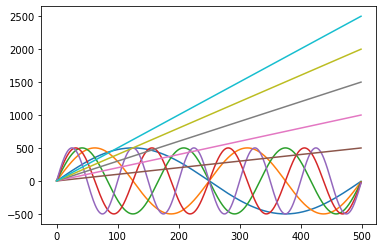

In [ ]:
# plt.figure()
# for tseries in M:
#   plt.plot(x,tseries)

In [26]:
D = out.cpu().detach().numpy()
D = D/np.max(D)

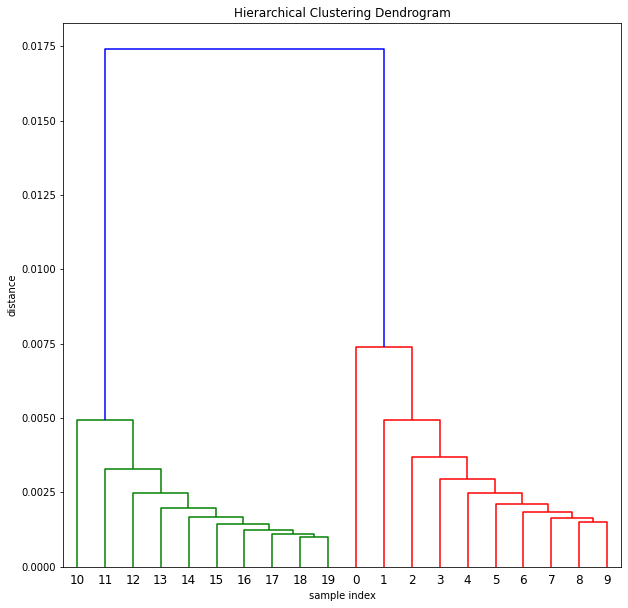

In [27]:
Z= linkage(D,method='single')
plt.figure(figsize=(10, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
ddata = dendrogram(
    Z,
)
plt.show()

In [38]:
d_crit = (percent_cluster_distance/100.) * np.max(ddata['dcoord'])
print(f"d_crit = {d_crit:0.03f}")

d_crit = 0.015


In [35]:
clusters = fcluster(Z, t=d_crit, criterion='distance')
print(clusters)
cluster1 = M[np.where(clusters==1)]
cluster2 = M[np.where(clusters==2)]

[2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1]


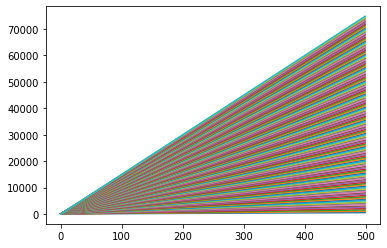

In [ ]:
plt.figure()
for tseries in cluster1:
  plt.plot(x,tseries)

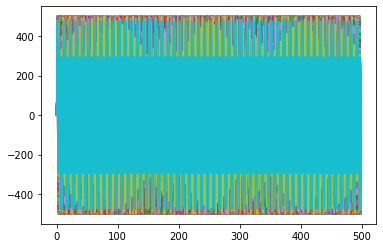

In [ ]:
plt.figure()
for tseries in cluster2:
  plt.plot(x,tseries)

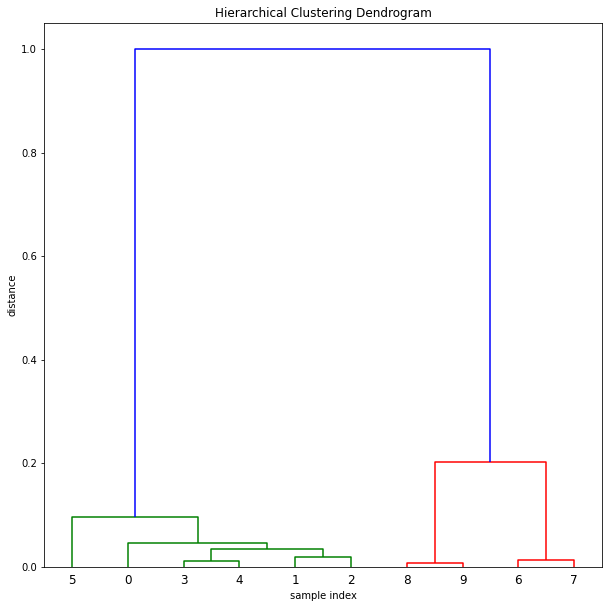

In [ ]:

# Z= linkage(D,method='complete')
# plt.figure(figsize=(10, 10))
# plt.title('Hierarchical Clustering Dendrogram')
# plt.xlabel('sample index')
# plt.ylabel('distance')
# dendrogram(
#     Z,
# )
# plt.show()

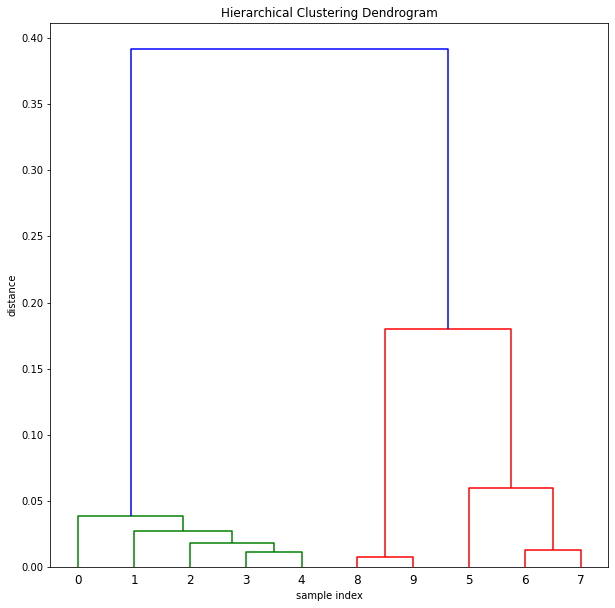

In [ ]:
# Z= linkage(D,method='average')
# plt.figure(figsize=(10, 10))
# plt.title('Hierarchical Clustering Dendrogram')
# plt.xlabel('sample index')
# plt.ylabel('distance')
# dendrogram(
#     Z,
# )
# plt.show()

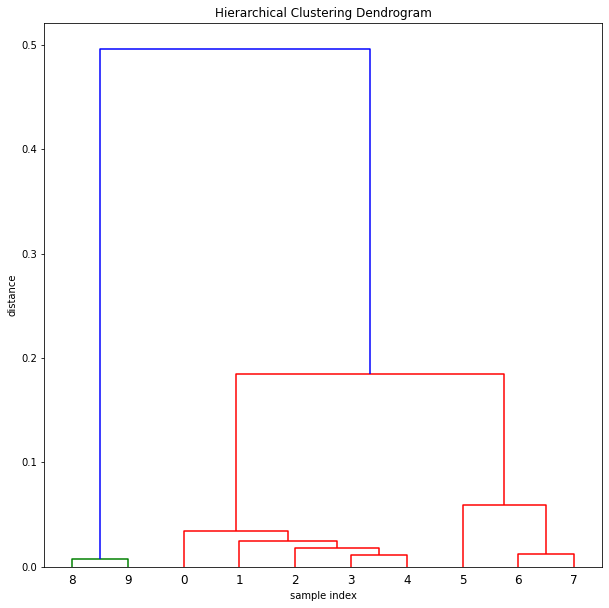

In [ ]:
# Z= linkage(D,method='weighted')
# plt.figure(figsize=(10, 10))
# plt.title('Hierarchical Clustering Dendrogram')
# plt.xlabel('sample index')
# plt.ylabel('distance')
# dendrogram(
#     Z,
# )
# plt.show()

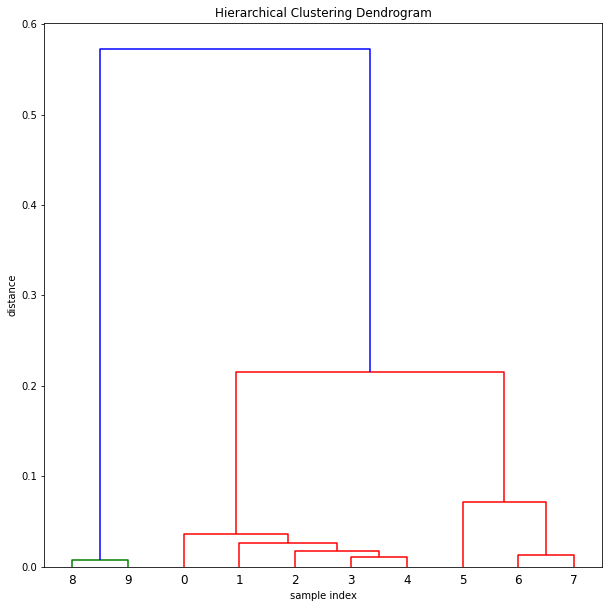

In [ ]:
# Z= linkage(D,method='centroid')
# plt.figure(figsize=(10, 10))
# plt.title('Hierarchical Clustering Dendrogram')
# plt.xlabel('sample index')
# plt.ylabel('distance')
# dendrogram(
#     Z,
# )
# plt.show()

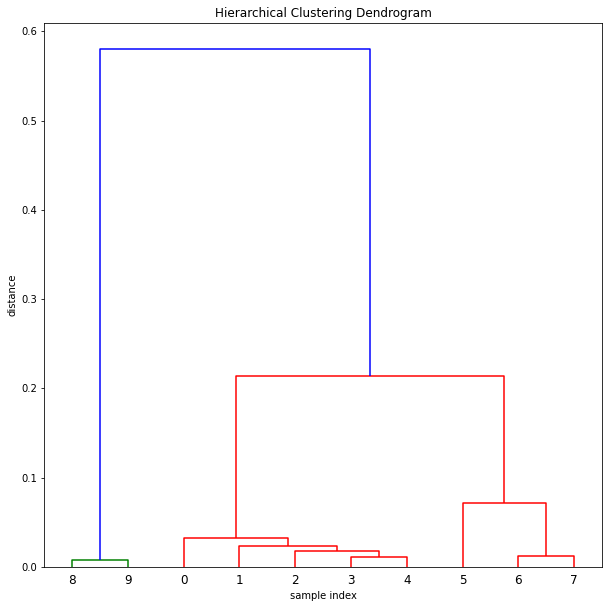

In [ ]:
# Z= linkage(D,method='median')
# plt.figure(figsize=(10, 10))
# plt.title('Hierarchical Clustering Dendrogram')
# plt.xlabel('sample index')
# plt.ylabel('distance')
# dendrogram(
#     Z,
# )
# plt.show()

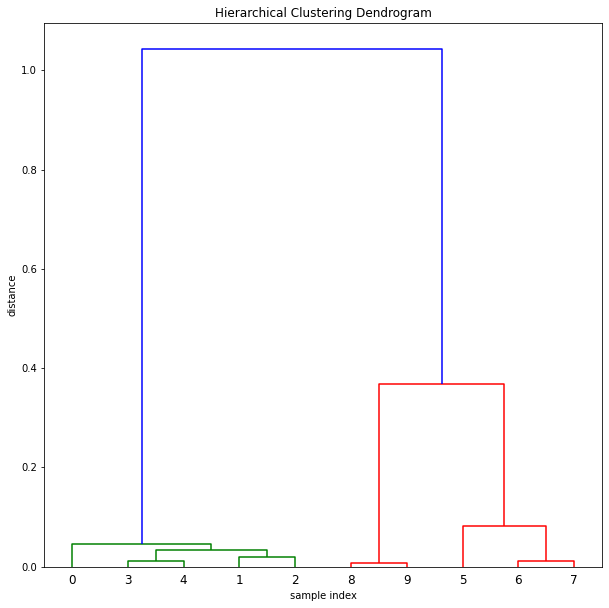

In [ ]:
# Z= linkage(D,method='ward')
# plt.figure(figsize=(10, 10))
# plt.title('Hierarchical Clustering Dendrogram')
# plt.xlabel('sample index')
# plt.ylabel('distance')
# dendrogram(
#     Z,
# )
# plt.show()

In [ ]:
# class_num = 1
# select = M[np.where(clusters==class_num)]
# for jj in range(np.shape(select)[0]):
#     plt.plot(x,select[jj,:])

In [ ]:
# class_num = 2
# select = M[np.where(clusters==class_num)]
# for jj in range(np.shape(select)[0]):
#     plt.plot(x,select[jj,:])